# Проектная работа

# Анализ оттока клиентов банка

**Описание**

Имеются данные о клиентах регионального банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

____
**Цель исследования.**

Проанализировать клиентов банка, и выделить сегменты клиентов, склонных к уходу. 
_____
**Задачи исследования.**

* Провести исследовательский анализ данных, определить все значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком, сравнить портреты типичных клиентов, которые склонны и не склонны уходить из банка и т.д)
* Сформулировать и проверить статистические гипотезы. Проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались. Сформулировать и проверить статистическую гипотезу относительно представленных данных, которая поможет внести ясность в исследование. 
* Объединяя признаки отточности, сформировать сегменты, отобрать из них лучшие и дать по ним рекомендации


1. [**Знакомство с данными**](#start)

2. [**Предобработка данных**](#prep)

* Привести формат заголовков столбцов к единому стилю
* Вывести и изучить уникальные значения столбцов, также минимальные, средние и максимальные значения
* Найти пропуски, явные или неявные дубликаты, принять решение об их удалении/обработке
    
    
3. [**Исследовательский анализ данных (EDA)**](#eda) 

    - Построить графики распределения клиентов по врем признакам, в том числе в разрезе оттока
    - Провести анализ корреляций среди различных признаков 
    - Составить портрет отточных клиентов по регионам,полу, возрасту и т.д

4. [**Проверка статистических гипотез**](#stats)

   Отложить в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):
    * [Гипотеза 1](#1) 
    * [Гипотеза 2](#1) 
    * [Гипотеза 3](#1)
    
    
5. [**Сегментация на основе стратегических показателей**](#segment)

* Провести сегментацию клиентов - выделить от 2-3 групп, в которых был наибольший уровень оттока
        
5. [**Выводы и базовые рекомендации по работе с клиентами**](#end)
    - Сформулировать основные выводы.
    - Предложить рекомендации для стратегии взаимодействия с клиентами и их удержания. 

## Знакомство с данными<a id="start"></a>

Имортируем необходимые для работы библиотеки

In [1]:
!pip install missingno

import pandas as pd
import os
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import scipy.stats as st

import numpy as np

import warnings
warnings.filterwarnings('ignore')

Сохраним данные в переменную и выведем их на экран, также отобразим информацию о датасете и типе файлов методом `info()`

In [2]:
file_path = 'bank_scrooge.csv'

try:
    bank = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"File not found: {file_path}")
except pd.errors.EmptyDataError:
    print(f"No data: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [3]:
bank.head( )

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Колонки содержат следущую информацию:

- `USERID` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — количество баллов собственности
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `EST_SALARY` — оценочный доход клиента,
- `сhurn` — признак оттока.

В датасете 12 колонок и 10 000 строк, есть пропуски. В датасете имеются целочисленные, вещественные и строковые типы данных.

Приступим к предобработке.

## Предобработка данных<a id="prep"></a>

Приведем названия колонок к единому типу

In [5]:
bank.columns = bank.columns.str.lower()

In [6]:
def check_columns(bank):
    for column in bank.columns:
        print('')
        print('======Уникальные значения столбца', column, "======")
        print(bank[column].unique())
        print('')
        print('Количество уникальных значений столбца', column, ":")
        print(bank[column].value_counts())

In [7]:
check_columns(bank.iloc[:,[1,2,3,4,5,7,8,9,11]])


======Уникальные значения столбца score ======
[ 850.  861.  892.  866.  730.  856.  807.  825.  923.  906.  927.  921.
  845.  837.  815.  731.  829.  793.  876.  922.  772.  896.  871.  732.
  898.  806.  766.  776.  868.  946.  828.  786.  944.  863.  822.  794.
  924.  811.  814.  956.  935.  826.  849.  901.  893.  792.  888.  831.
  748.  820.  860.  914.  930.  948.  789.  737.  812.  933.  809.  749.
  873.  859.  950.  937.  835.  768.  767.  785.  846.  750.  816.  894.
  891.  788.  758.  787.  821.  855.  779.  791.  838.  971.  797.  841.
  915.  985.  870.  897.  763.  774.  686. 1000.  875.  819.  869.  854.
  810.  761.  802.  958.  917.  745.  736.  908.  928.  884.  853.  780.
  726.  881.  975.  852.  965.  899.  890.  836.  818.  880.  795.  916.
  775.  902.  918.  842.  771.  895.  801.  721.  966.  804.  885.  986.
  753.  832.  979.  798.  754.  756.  823.  658.  734.  954.  827.  929.
  760.  688.  659.  817.  718.  705.  920.  652.  649.  862.  770.  824.
  9

Изучим количество пропусков

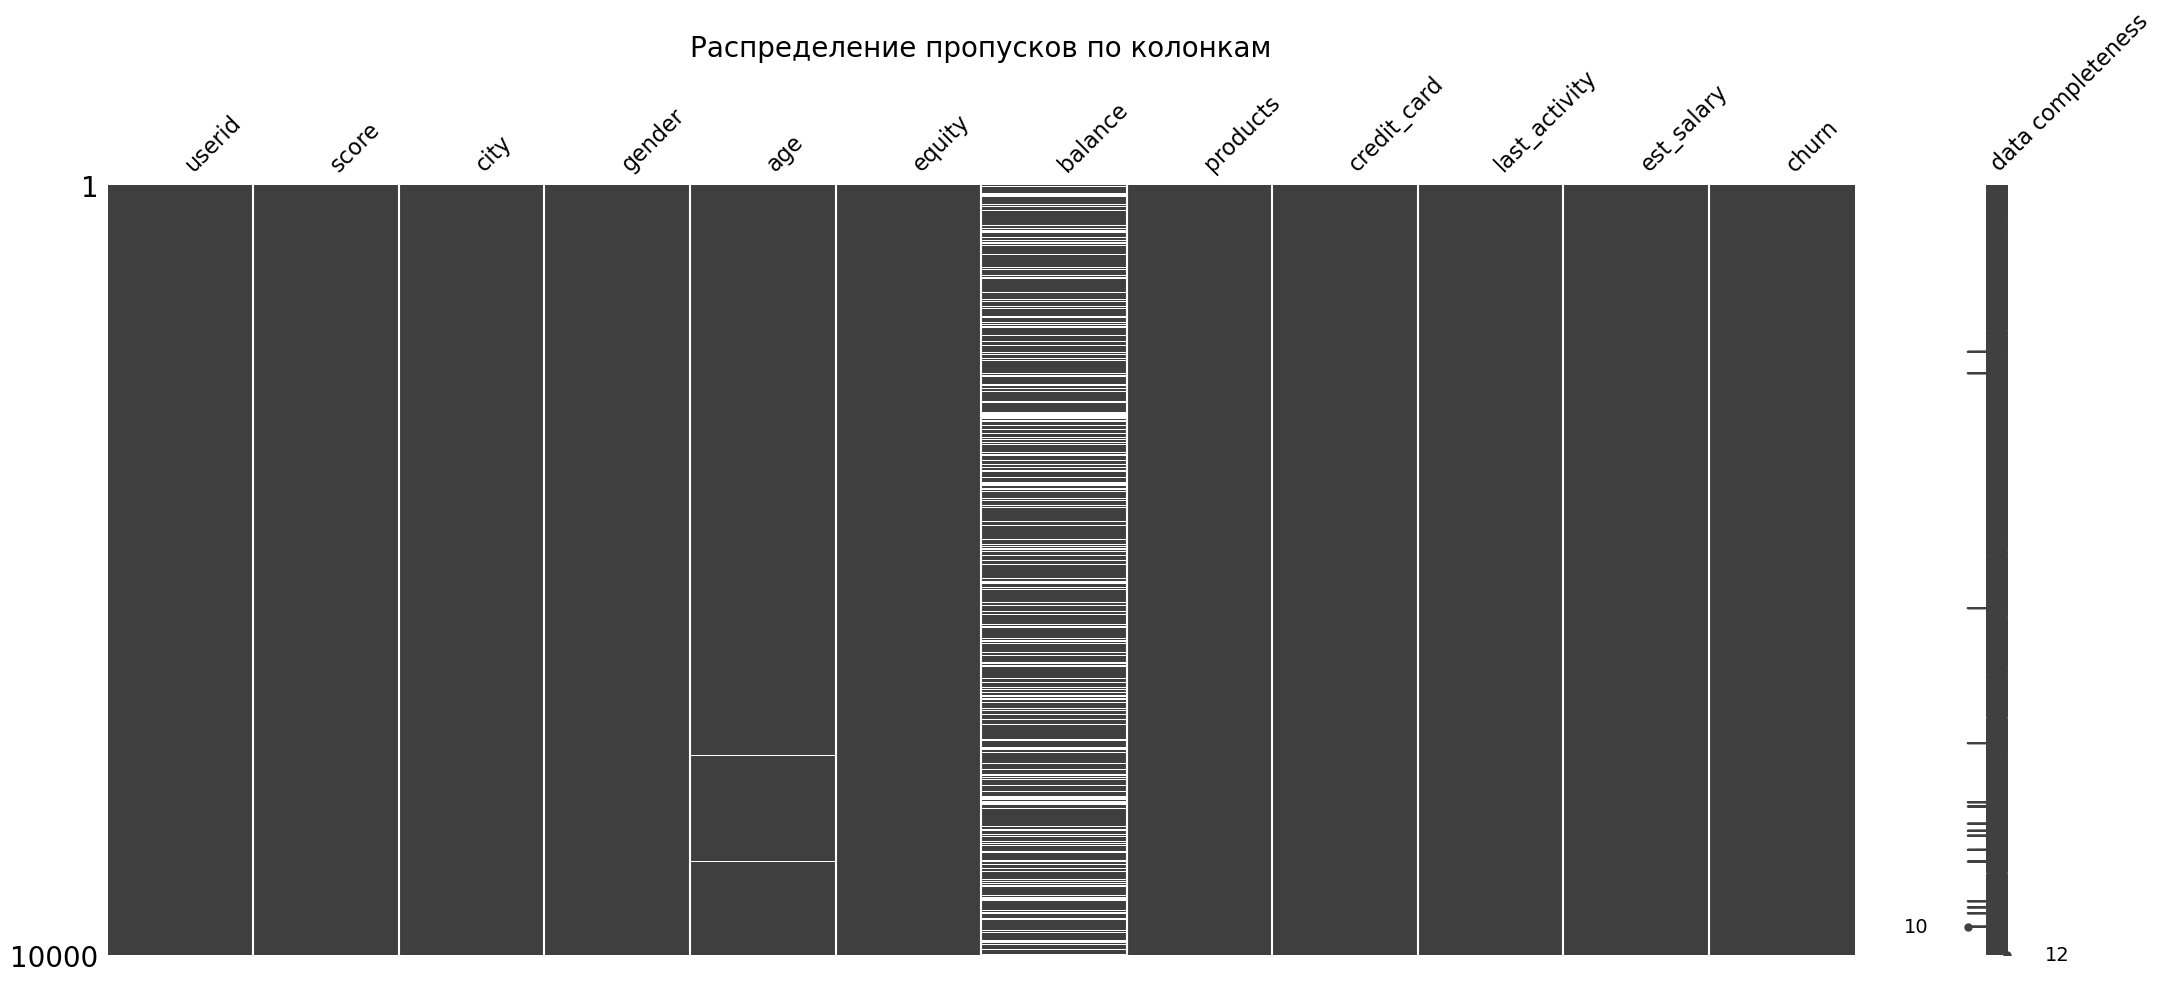

Количество пропусков в колонках:


userid              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [8]:
msno.matrix(bank,labels=True)
plt.title('Распределение пропусков по колонкам', fontsize=20)
plt.show();
print('Количество пропусков в колонках:')
bank.isna().sum()

Почти 2300 пропусков в колонке с балансом клиентов, и 26 в колонке с возрастом

Посмотрим на корреляцию пропусков между собой

In [9]:
df = bank.iloc[:, [i for i, n in enumerate(np.var(bank.isna(), axis = 'rows')) if n > 0]]
df.isna().corr()

,age,balance
age,1.000000,0.046852
balance,0.046852,1.000000


Есть незначительная корреляция между пропусками в `age` и `balance`

Посмотрим на рандомные записи среза с пропусками

In [10]:
bank[bank['balance'].isna()].sample(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7836,131989,893.0,Ярославль,М,47.0,0,NaN,1,1,1,184100.52,0
7618,203020,956.0,Ярославль,М,37.0,0,NaN,1,1,0,349055.58,0
5014,187428,937.0,Рыбинск,М,19.0,0,NaN,1,1,0,74801.48,0
7982,176541,707.0,Ярославль,Ж,35.0,0,NaN,1,1,1,968740.75,0
8822,199312,911.0,Рыбинск,Ж,43.0,0,NaN,2,1,1,152189.72,0
3819,159471,893.0,Ярославль,М,30.0,0,NaN,1,1,0,89623.92,0
8808,182246,728.0,Рыбинск,Ж,63.0,0,NaN,1,1,1,188590.62,0
2681,180034,939.0,Ярославль,М,50.0,0,NaN,1,0,1,172062.20,0
7926,141188,910.0,Ярославль,Ж,71.0,0,NaN,1,0,1,222073.05,0
3065,141877,898.0,Ростов,М,53.0,0,NaN,1,1,1,131444.72,0


Все три города есть в срезе, посмотрим на наличие здесь других признаков 

In [11]:
print(bank[bank['balance'].isna()]['products'].value_counts())
print(bank[bank['balance'].isna()]['churn'].value_counts())
print(bank[bank['balance'].isna()]['equity'].value_counts())
print(bank[bank['balance'].isna()]['credit_card'].value_counts())

1    1950
2     315
3      29
0       1
Name: products, dtype: int64
0    2282
1      13
Name: churn, dtype: int64
0    2180
1     114
3       1
Name: equity, dtype: int64
1    1872
0     423
Name: credit_card, dtype: int64


Видно, что в срез с пропусками в балансе вошли и отточные, и не отточные пользователи с количеством продуктов 0, 1, 2, 3, и баллами собственности 0, 1, 3, а также с кредитками и без.

Мы не знаем природу этих пропусков - может быть, пропуск означает нулевой баланс, или эти данные просто отсутствуют по какой-либо другой причине. Возможно, пользователи были зарегистрированы в банке, и имеют одобренные кредитки и продукты, но не пользуются этим - карты не активны, поэтому баланс не отображается.

Заполним пропуски нулями, чтобы в дальнейшем у нас не было сложностей с проведением тестирования.

В датасете есть одна запись, где количество продуктов равно 0, и поскольку клиентами банка считаются те пользователи, у которых есть хотя бы 1 продукт, мы удалим эту запись.

In [12]:
bank = bank.loc[bank['products'] != 0]
bank['balance'] = bank['balance'].fillna(0)

Пропусков в возрасте немного, посмотрим на этих пользователей:

In [13]:
bank[bank['age'].isna()]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,0.00,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,0.00,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,0.00,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,0.00,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


Строки с этими пользователями содержат данные о продуктах, собственности, и др. Не будем их удалять, заменим средним значением возраста по полу, поскольку средний возраст мужчин и женщин обычно различается.

In [14]:
grp = bank.groupby(['gender'])
bank['age'] = grp.age.apply(lambda x: x.fillna(x.median()))

Проверим датасет на явные дубликаты:

In [15]:
bank.duplicated().sum()

0

Явных дубликатов нет, проверим на дубликаты по `userid`:

In [16]:
bank.loc[bank[['userid']].duplicated(keep=False)].sort_values(by='userid')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,0.00,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,0.00,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,0.00,1,1,1,146427.96,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0
6457,228075,839.0,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0


146 дубликатов в  ID пользователей. Мы не можем знать причины появления этих дубликатов, возможно, какие-то пользователи оформляли карты и прочие услуги банка в разных городах, или перевыпускали карты. В любом случае, дубликатов немного, удалим их, оставив только первые вхождения этих пользователей.

In [17]:
bank.drop_duplicates(subset='userid', inplace=True)

Выведем средние, максимальные и минимальные значения датасета.

In [18]:
display(bank.describe().round(2))

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9926.00,9926.00,9926.00,9926.00,9.926000e+03,9926.00,9926.00,9926.00,9926.00,9926.00
mean,171741.48,848.72,42.72,2.63,6.402568e+05,1.87,0.68,0.52,147903.79,0.18
std,33697.33,65.39,12.17,1.98,1.779053e+06,0.79,0.47,0.50,139367.41,0.39
min,94561.00,642.00,18.00,0.00,0.000000e+00,1.00,0.00,0.00,2546.30,0.00
25%,142715.00,802.00,33.00,0.00,6.395782e+04,1.00,0.00,0.00,75252.07,0.00
50%,172654.00,853.00,40.00,3.00,3.765628e+05,2.00,1.00,1.00,119715.39,0.00
75%,201161.75,900.00,51.00,4.00,8.053314e+05,2.00,1.00,1.00,174679.64,0.00
max,229145.00,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00


Видно, что в колонке `est_salary` есть аномально низкие и высокие значения. Поскольку нам известно, что данные, представленные в этой колонке были спрогнозированы моделью, можно допустить вероятность того, что тут могут оказаться выбросы.

Отобразим выбросы в колонках `balance` и `est_salary`

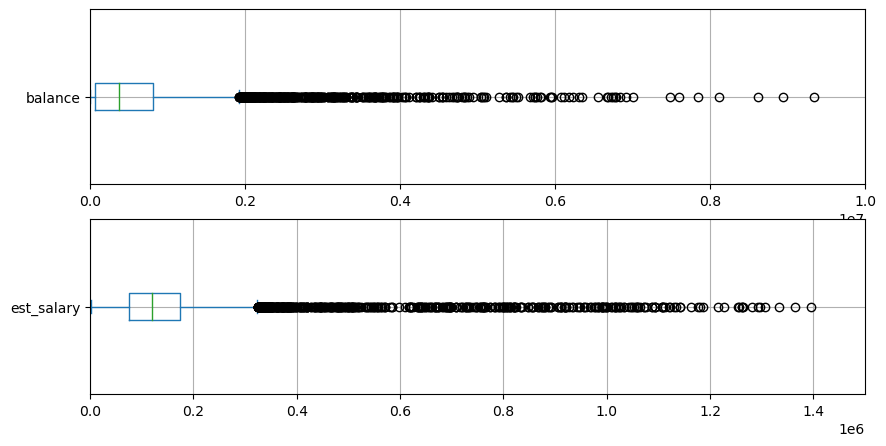

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,5))

bank['balance'].plot(kind='box', vert=False, ax=axes[0], grid=True)
axes[0].set_xlim([0, 10000000])

bank['est_salary'].plot(kind='box', vert=False, ax=axes[1], grid=True)
axes[1].set_xlim([0, 1500000])

plt.show();

Если бы мы знали, информация какого года представленя в датасете, то ограничили бы прогнозируемый доход актуальным на тот год значением минимальной заработной платы. Возьмем приблизительное значение - 13000р. Также удалим выбросы по 95 перцентилю.

In [20]:
bnk = (bank[bank['est_salary'] <= np.percentile(bank['est_salary'], 95)]).query('est_salary >= 13000')

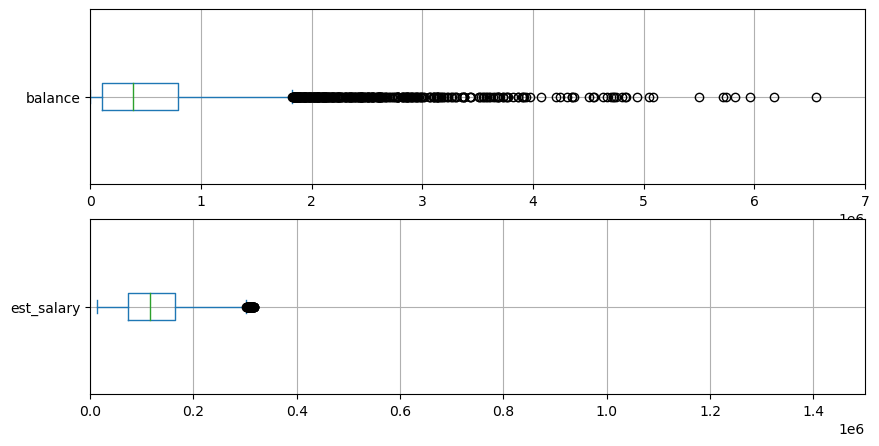

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,5))

bnk['balance'].plot(kind='box', vert=False, ax=axes[0], grid=True)
axes[0].set_xlim([0, 7000000])

bnk['est_salary'].plot(kind='box', vert=False, ax=axes[1], grid=True)
axes[1].set_xlim([0, 1500000])

plt.show();

In [22]:
bnk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9392 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9392 non-null   int64  
 1   score          9392 non-null   float64
 2   city           9392 non-null   object 
 3   gender         9392 non-null   object 
 4   age            9392 non-null   float64
 5   equity         9392 non-null   int64  
 6   balance        9392 non-null   float64
 7   products       9392 non-null   int64  
 8   credit_card    9392 non-null   int64  
 9   last_activity  9392 non-null   int64  
 10  est_salary     9392 non-null   float64
 11  churn          9392 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 953.9+ KB


Видим, что в датафрейме осталось 9362 строки - мы удалили менее 10%

Создадим дамми-переменные для столбца с городами и полом и выведем 5 рандомных строчек чтобы проверить работу переменной:

In [23]:
# Создаем дамми-переменные для столбца 'city' и 'gender'
cities = pd.get_dummies(bnk['city'], columns=['city'], prefix='')
gender = pd.get_dummies(bnk['gender'], columns=['gender'], prefix='')
bnk = pd.concat([bnk, cities], axis=1)
bnk = pd.concat([bnk, gender], axis=1)
bnk.sample(5)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,_Ростов,_Рыбинск,_Ярославль,_Ж,_М
6989,205724,873.0,Ярославль,Ж,37.0,5,1445150.81,2,1,1,95970.45,1,0,0,1,1,0
4548,192908,912.0,Ярославль,М,30.0,1,0.00,1,1,0,58965.97,0,0,0,1,0,1
9770,197864,851.0,Рыбинск,Ж,31.0,3,750116.48,2,0,1,132387.04,0,0,1,0,1,0
1821,175415,835.0,Ярославль,Ж,64.0,0,248861.54,1,1,0,129678.52,0,0,0,1,1,0
2945,196492,826.0,Ярославль,Ж,51.0,1,316501.90,2,1,1,97439.69,0,0,0,1,1,0


Мы Проверили датасет на пропуски и дубликаты, удалили ненужные дубликаты и выбросы, создали столбцы с дамми-переменными, и можем начинать исследовательский анализ данных.

## Исследовательский анализ данных (EDA)<a id="eda"></a>

Построим графики распределения признаков по отточным и не отточным клиентам

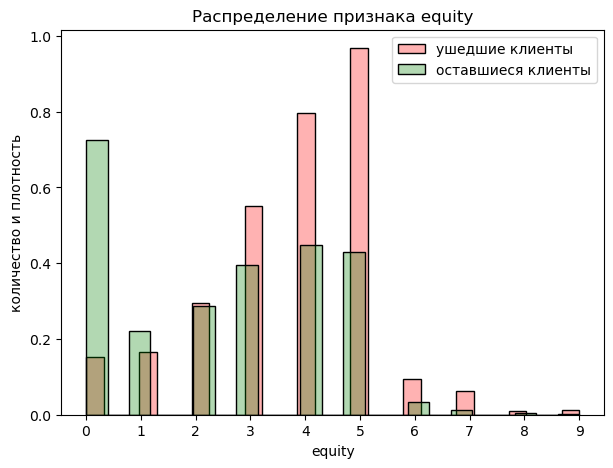

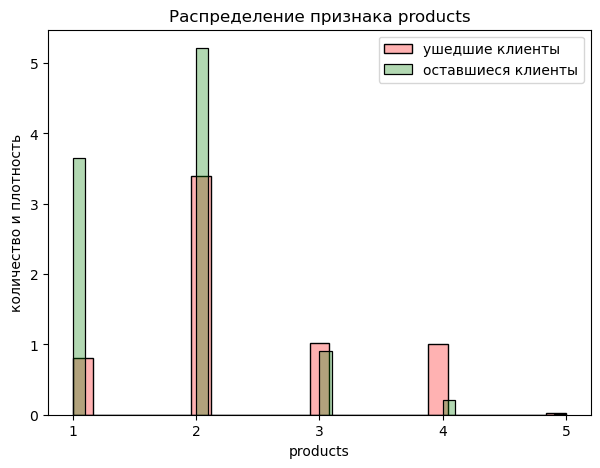

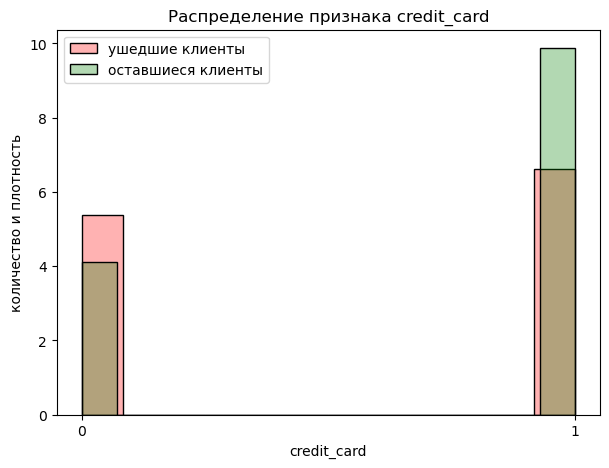

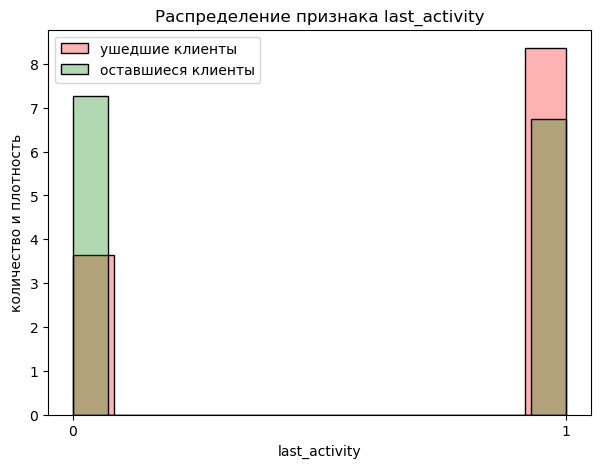

In [24]:
good = bnk.query('churn == 0')
bad = bnk.query('churn == 1')

for column in bnk[['equity','products','credit_card','last_activity']].columns:
    fig, ax = plt.subplots(figsize=(7,5))
    plt.title('Распределение признака ' + column)
    plt.xlabel(column)
    plt.ylabel('количество и плотность')
    sns.histplot(bad[column], label='ушедшие клиенты',color='red', stat='density', alpha=0.3, common_norm=False)
    sns.histplot(good[column], label='оставшиеся клиенты',color='green', stat="density",alpha=0.3, common_norm=False)
    plt.xticks(np.unique(good[column]))
    plt.legend()
    plt.show()

Видно, что распределение по отточным и не отточным пользователям проходит следующим образом:

* По количеству продуктов в собственности:

    * не отток - 4 продукта
    * отток - 5 продуктов
    
* По продуктам: в общем обе категории пользователей чаще всего имеют 2 продукта. Скорее всего, это дебетовая и кредитная карты

* По кредиткам: Видно, что большая часть пользователей имеет кредитную карту, и не отточных среди них больше всего

* Активность: оставшиеся пользователи в большинстве своем неактивны, ну а высокие показатели оттока в районе 1 по оси х могут говорить об активности, связанной с отказом от услуг банка.

Рассмотрим распределение по категориальным величинам:

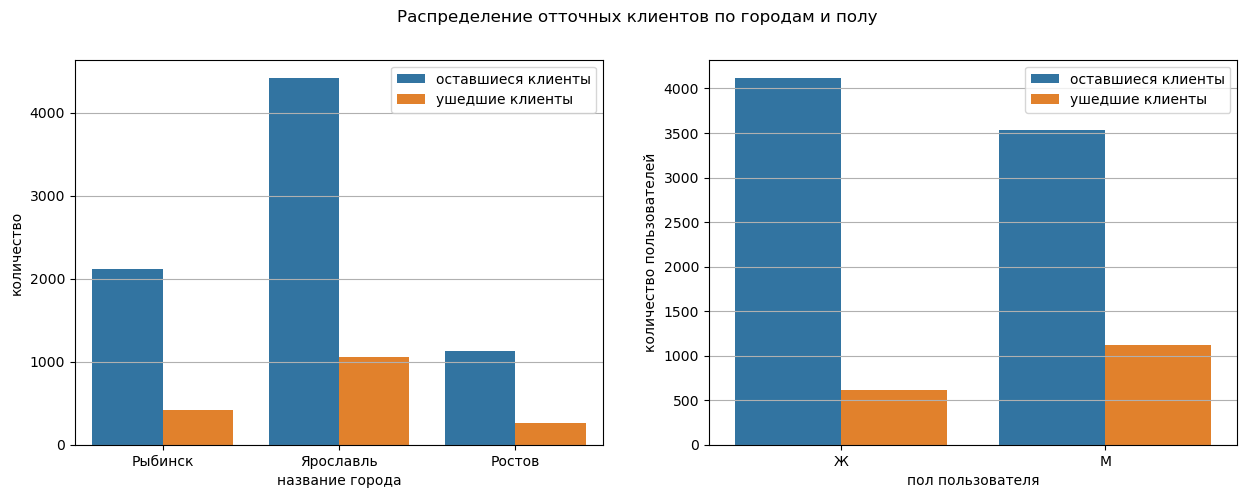

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Распределение отточных клиентов по городам и полу')

for ax in axes:
    ax.yaxis.grid(True)
    
sns.countplot(ax=axes[0], data=bnk, x='city', hue='churn').set(title='', xlabel='название города', ylabel='количество')
axes[0].legend(title='', labels=['оставшиеся клиенты', 'ушедшие клиенты'])

sns.countplot(ax=axes[1],  data=bnk, x='gender', hue='churn').set(title='', xlabel='пол пользователя', ylabel='количество пользователей')
axes[1].legend(title='', labels=['оставшиеся клиенты', 'ушедшие клиенты'])
plt.show();

Видно что основная масса отточных и неотточных пользователей скопилась в Ярославле. По распределению по полу среди мужчин больше отточных пользователей.

Рассмотрим распределение оценочного дохода и баланса среди отточных и не отточных клиентов

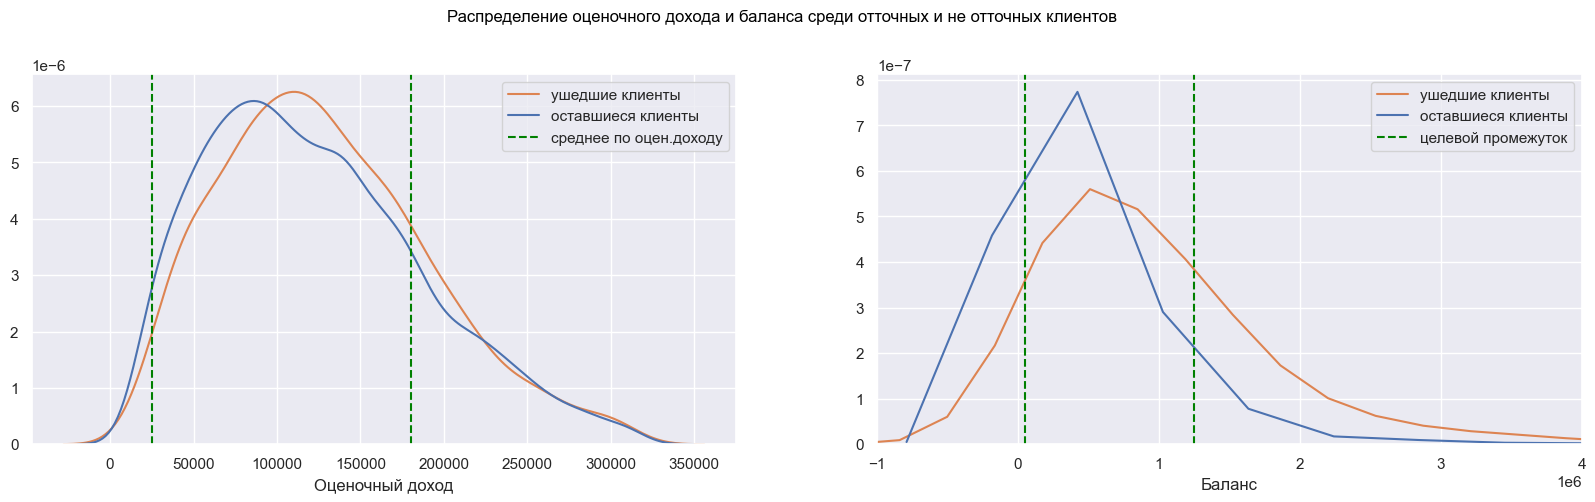

In [26]:
plt.rcParams ['figure.figsize'] = [20, 5]
plt.suptitle('Распределение оценочного дохода и баланса среди отточных и не отточных клиентов')
sns.set()
plt.subplots_adjust(top= 0.85 )

plt.subplot(1, 2, 1)
sns.kdeplot(data=bnk, x='est_salary', hue='churn', common_norm=False)
plt.axvline(x=25000, color='green', linestyle='--')
plt.axvline(x=180000, color='green', linestyle='--')
plt.xlabel('Оценочный доход')
plt.ylabel('')
plt.legend(title='', loc='upper right', labels=['ушедшие клиенты', 'оставшиеся клиенты', 'среднее по оцен.доходу'])

plt.subplot(1, 2, 2)
sns.kdeplot(data=bnk, x='balance', hue='churn', common_norm=False)
plt.axvline(x=50000, color='green', linestyle='--')
plt.axvline(x=1250000, color='green', linestyle='--')
plt.gca().set_xlim(-1000000, 4000000)
plt.xlabel('Баланс')
plt.ylabel('')
plt.legend(title='', loc='upper right', labels=['ушедшие клиенты','оставшиеся клиенты', 'целевой промежуток'])

plt.show();

Видно, что по оценочному доходу отточные пользователи лидируют и пик находится на уровне 25 000 - 180 000, а по балансу отточные пользователи превышают не отточных только после преодоления средних значений, основной пласт пользователей скопился в районе 100 000 - 700 000 баланса

Построим распределение по возрасту среди отточных и не отточных клиентов:

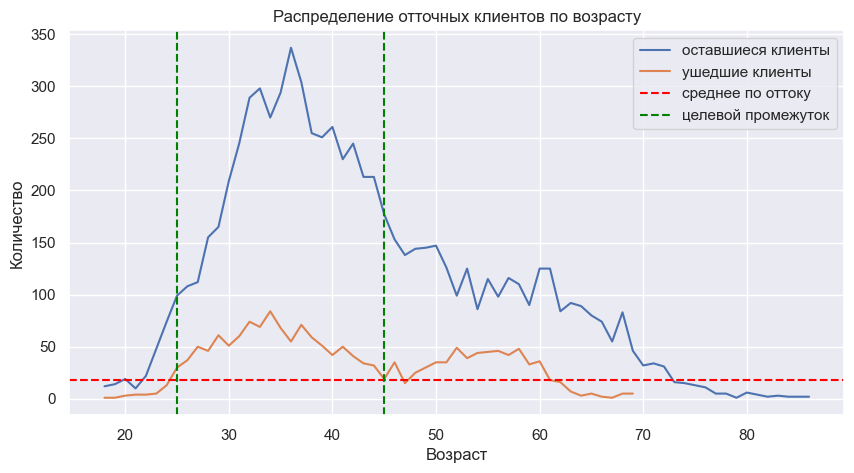

In [27]:
grouped = bnk.groupby(['age', 'churn']).size().reset_index(name='count')
pivot = grouped.pivot(index='age', columns='churn', values='count').reset_index()
pivot.columns = ['age','good','bad']

pivot.plot(x='age',figsize=(10,5))
plt.axhline((bnk['churn'].sum()/len(bnk))*100, color='red', linestyle='--')
plt.axvline(x=25, color='green', linestyle='--')
plt.axvline(x=45, color='green', linestyle='--')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend(title='', loc='upper right', labels=['оставшиеся клиенты',
                                                'ушедшие клиенты',
                                                'среднее по оттоку',
                                                'целевой промежуток'])
plt.title('Распределение отточных клиентов по возрасту')

plt.show()

Видно что пик распределения приходится на возраст 25-45 лет. Это основная масса. Есть также небольшой всплеск оттока в районе 50-60 лет. Возможно, это связано со смертью клиента.

Построим распределение среди клиентов по баллам кредитного рейтинга:

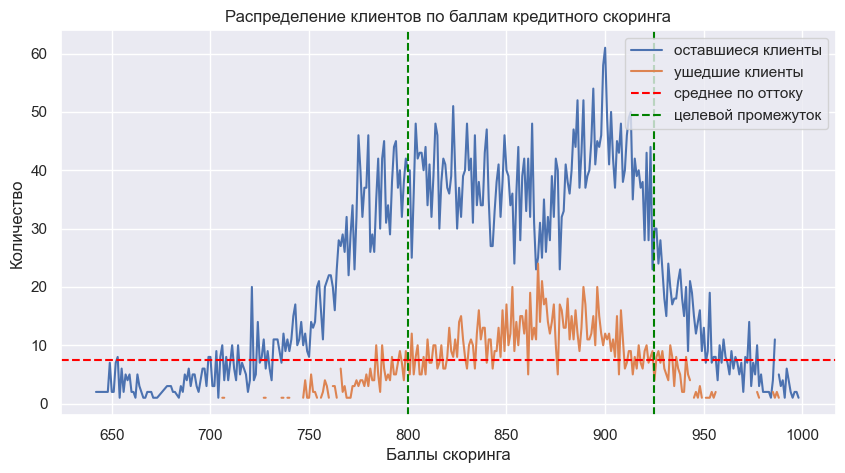

In [28]:
grouped2 = bnk.groupby(['score', 'churn']).size().reset_index(name='count')

pivot2 = grouped2.pivot(index='score', columns='churn', values='count').reset_index()
pivot2.columns = ['score','good','bad']

pivot2.plot(x='score',figsize=(10,5))
plt.axhline(pivot2['bad'].mean(), color='red', linestyle='--')
plt.axvline(x=800, color='green', linestyle='--')
plt.axvline(x=925, color='green', linestyle='--')
plt.xlabel('Баллы скоринга')
plt.ylabel('Количество')
plt.legend(title='', loc='upper right', labels=['оставшиеся клиенты',
                                                'ушедшие клиенты',
                                                'среднее по оттоку',
                                                'целевой промежуток'])
plt.title('Распределение клиентов по баллам кредитного скоринга')
plt.show()

Видно что в среднем баллы большего количества отточных клиентов выше, чем средние баллы большего количества не отточных.

Построим тепловую карту корреляции между всеми признаками:

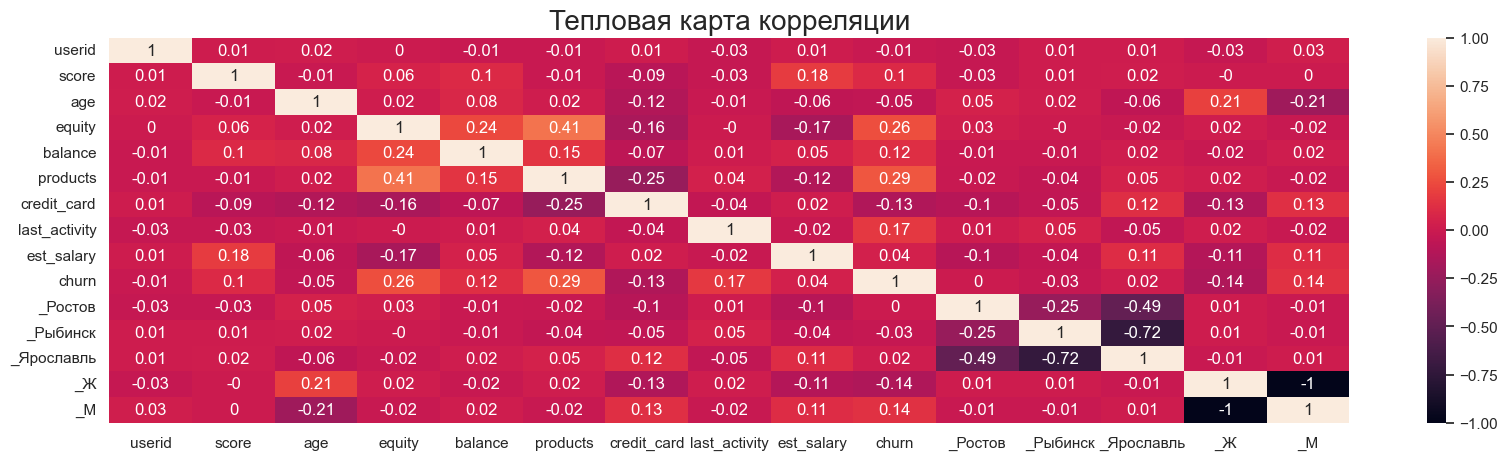

In [29]:
plt.figure(figsize=(20, 5))
sns.heatmap(bnk.corr().round(2), annot=True)
plt.title('Тепловая карта корреляции', fontsize=20);

Видно что в целом корреляции по датасету почти нет, только небольшие повышенные значения между `equity` и `balance`, и между `score` и `balance

Построим графики корреляции между этими признаками

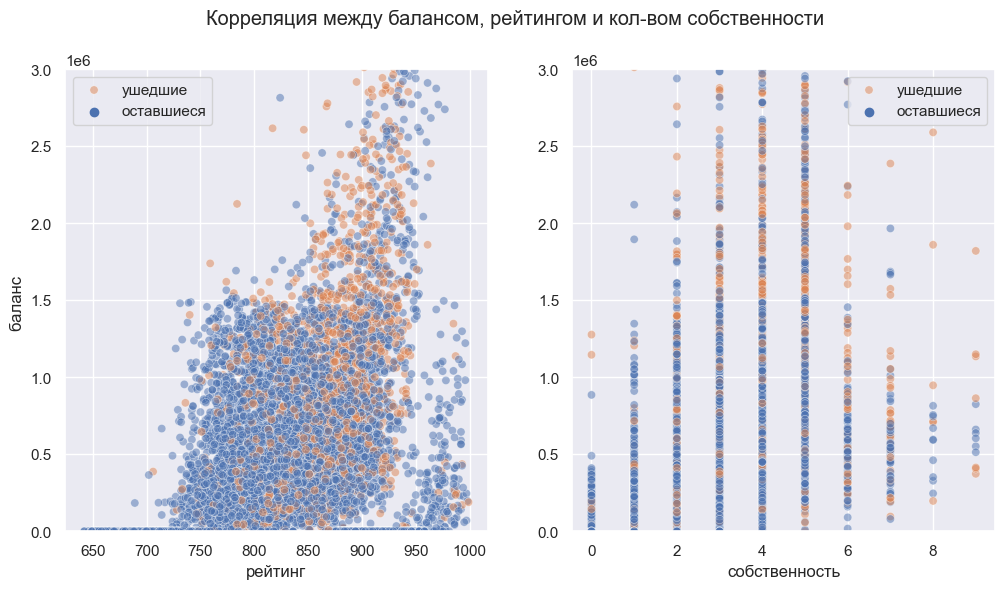

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Корреляция между балансом, рейтингом и кол-вом собственности')

sns.scatterplot(ax=axes[0], data=bnk, y='balance', x='score', hue='churn', alpha=0.5)\
                .set(title='', xlabel='рейтинг', ylabel='баланс ')
axes[0].legend(title='', loc='upper left', labels=['ушедшие','оставшиеся'])
axes[0].set_ylim([0, 3000000])

sns.scatterplot(ax=axes[1],  data=bnk, y='balance', x='equity', hue='churn', alpha=0.5)\
                .set(title='', xlabel='собственность', ylabel='')
axes[1].legend(title='', loc='upper right', labels=['ушедшие','оставшиеся'])
axes[1].set_ylim([0, 3000000])
plt.show();

Видно распределение корреляции между балансом, рейтингом и кол-вом собственности, чем выше баланс, тем выше баллы рейтинга и собственности и у отточных, и у не отточных клиентов.

Создадим сводную таблицу средних и модальных значений отточных и не отточных пользователей

In [31]:
piv_user = bnk.groupby('churn').agg(score_mean=('score','mean'),
                                    age_mode=('age', pd.Series.mode),
                                    city_mode=('city', pd.Series.mode),
                                   equity_mode=('equity', pd.Series.mode),
                                   products_mode=('products', pd.Series.mode),
                                   balance_median=('balance','median'),
                                   salary_median=('est_salary','median'),
                                   men=('_М','mean'),
                                   women=('_Ж','mean'),
                                   cr_card_mode=('credit_card', pd.Series.mode)).round(2)
piv_user.T

churn,0,1
score_mean,843.97,860.66
age_mode,36.0,34.0
city_mode,Ярославль,Ярославль
equity_mode,0,5
products_mode,2,2
balance_median,334946.35,751369.51
salary_median,113967.69,121302.95
men,0.46,0.65
women,0.54,0.35
cr_card_mode,1,1


Исходя из проведенного исследовательского анализа данных, можно сформировать примерный портрет отточного пользователя банка "Метанпром":

* кредитный рейтинг 800-925 баллов, среднее - 853 
* возраст - 25-45 лет, наиболее часто встречающееся значение возраста - 34
* город - Ярославль, наиболее крупный из всех имеющихся
* баллы собственности - 4
* количество продуктов - 2
* баланс - 50 000-700 000, и среднее ~ 625 000
* прогнозируемый заработок - 25 000-180 000 и среднее ~ 112 000
* пол - мужчина (64% мужчин и 36% женщин)

## Проверка гипотез<a id="stats"></a>

Сформулируем гипотезы:

### Гипотеза 1<a id="1"></a>

**Н0: Средний доход отточных и не отточных пользователей одинаковый**

**Н1: Средний доход отточных и не отточных пользователей различается**

Сначала выполним тест Шапиро-Уилка для этой выборки, чтобы определить, является ли она результатом нормального распределения.
При p-значении меньше 0.05 мы будем вынуждены отклонить нулевую гипотезу:

* нулевая гипотеза – данные распределены нормально
* альтернативная гипотеза – данные не имеют нормального распределения

In [32]:
stat, p = st.shapiro(bnk.query('churn == 0')['est_salary'])
stat2, p2 = st.shapiro(bnk.query('churn == 1')['est_salary'])

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности первой выборки')
else:
    print('Отклонить гипотезу о нормальности первой выборки')

if p2 > alpha:
    print('Принять гипотезу о нормальности второй выборки')
else:
    print('Отклонить гипотезу о нормальности второй выборки')

Отклонить гипотезу о нормальности первой выборки
Отклонить гипотезу о нормальности второй выборки


Теперь мы можем сказать, что данные выборки получены из ненормального распределения, и применим U-критерий Манна-Уитни для проверки гипотезы.

Установим значение *alpha = 0.05*

In [33]:
alpha = 0.05 

good = bnk.query('churn == 0')['est_salary']
bad = bnk.query('churn == 1')['est_salary']

results = st.mannwhitneyu(good, bad)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Средний доход оставшихся пользователей - {:.2f}'.format(good.mean()))
print('Средний доход ушедших пользователей - {:.2f}'.format(bad.mean()))

p-значение: 2.846730596570132e-05
Отвергаем нулевую гипотезу
Средний доход оставшихся пользователей - 122363.96
Средний доход ушедших пользователей - 128444.09


Отвергаем нулевую гипотезу - средний доход отточных и не отточных пользователей различается

### Гипотеза 2<a id="2"></a>

**Н0: Баллы рейтинга отточных мужчин и женщин одинаковые**

**Н1: Баллы рейтинга отточных мужчин и женщин различаются**

Выполним тест Шапиро-Уилка:
* нулевая гипотеза – данные распределены нормально
* альтернативная гипотеза – данные не имеют нормального распределения

In [34]:
stat, p = st.shapiro(bnk.query('churn == 0 and gender == "Ж"')['score'])
stat2, p2 = st.shapiro(bnk.query('churn == 0 and gender == "М"' )['score'])

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности первой выборки')
else:
    print('Отклонить гипотезу о нормальности первой выборки')

if p2 > alpha:
    print('Принять гипотезу о нормальности второй выборки')
else:
    print('Отклонить гипотезу о нормальности второй выборки')

Отклонить гипотезу о нормальности первой выборки
Отклонить гипотезу о нормальности второй выборки


Также применим U-критерий Манна-Уитни для проверки гипотезы.

Установим значение *alpha = 0.05*

In [35]:
alpha = 0.05 

mscore = bnk.query('churn == 0 and gender == "Ж"')['score']
wscore = bnk.query('churn == 0 and gender == "М"' )['score']

results = st.mannwhitneyu(mscore, wscore)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Средний рейтинг ушедших мужчин - {:.2f}'.format(mscore.mean()))
print('Средний рейтинг ушедших женщин - {:.2f}'.format(wscore.mean()))

p-значение: 0.8449487449704902
Не получилось отвергнуть нулевую гипотезу
Средний рейтинг ушедших мужчин - 844.36
Средний рейтинг ушедших женщин - 843.52


Не получилось отвергнуть нулевую гипотезу - средний рейтинг ушедших мужчин и женщин одинаковый

### Гипотеза 3<a id="3"></a>

**Н0: Средний возраст отточных мужчин и женщин одинаковый**

**Н1: Средний возраст отточных мужчин и женщин различаются**

Выполним тест Шапиро-Уилка:
* нулевая гипотеза – данные распределены нормально
* альтернативная гипотеза – данные не имеют нормального распределения

In [36]:
stat, p = st.shapiro(bnk.query('churn == 0 and gender == "М"')['age'])
stat2, p2 = st.shapiro(bnk.query('churn == 0 and gender == "Ж"')['age'])

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности первой выборки')
else:
    print('Отклонить гипотезу о нормальности первой выборки')

if p2 > alpha:
    print('Принять гипотезу о нормальности второй выборки')
else:
    print('Отклонить гипотезу о нормальности второй выборки')

Отклонить гипотезу о нормальности первой выборки
Отклонить гипотезу о нормальности второй выборки


Также применим U-критерий Манна-Уитни для проверки гипотезы.

Установим значение *alpha = 0.05*

In [37]:
alpha = 0.05 

men = bnk.query('churn == 0 and gender == "М"')['age']
women = bnk.query('churn == 0 and gender == "Ж"')['age']

results = st.mannwhitneyu(men, women)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Средний возраст ушедших мужчин - {:.2f}'.format(men.mean()))
print('Средний возраст ушедших женщин - {:.2f}'.format(women.mean()))

p-значение: 6.543986676101288e-67
Отвергаем нулевую гипотезу
Средний возраст ушедших мужчин - 40.09
Средний возраст ушедших женщин - 45.56


Отвергаем нулевую гипотезу - средний возраст отточных мужчин и женщин различается

## Сегментация пользователей<a id="segment"></a>

На основе полученных данных выделим несколько групп пользователей с наибольшим оттоком

In [38]:
print('Процент оттока по датафрейму - {:.1f}'.format(bnk['churn'].mean()*100))

Процент оттока по датафрейму - 18.5


**Разделим пользователей на сегменты и отобразим процент оттока по каждому сегменту**

Напишем функцию для отображения графиков с долями:

In [39]:
def plot_churn_rate(df):
    churn_rate = df['churn'].mean() * 100
    labels = ['отток', 'не отток']
    sizes = [churn_rate, 100.0 - churn_rate]
    explode = [0.1,0]
    print('Размер сегмента - {:.0f}'.format(len(df)))
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%.1f%%')
    ax1.axis('equal')
    plt.title('Доля отточных пользователей в сегменте', fontsize=15)
    plt.show()

Сформируем первый сегмент, возьмем мужчин от 25 до 45 лет:

Размер сегмента - 3216


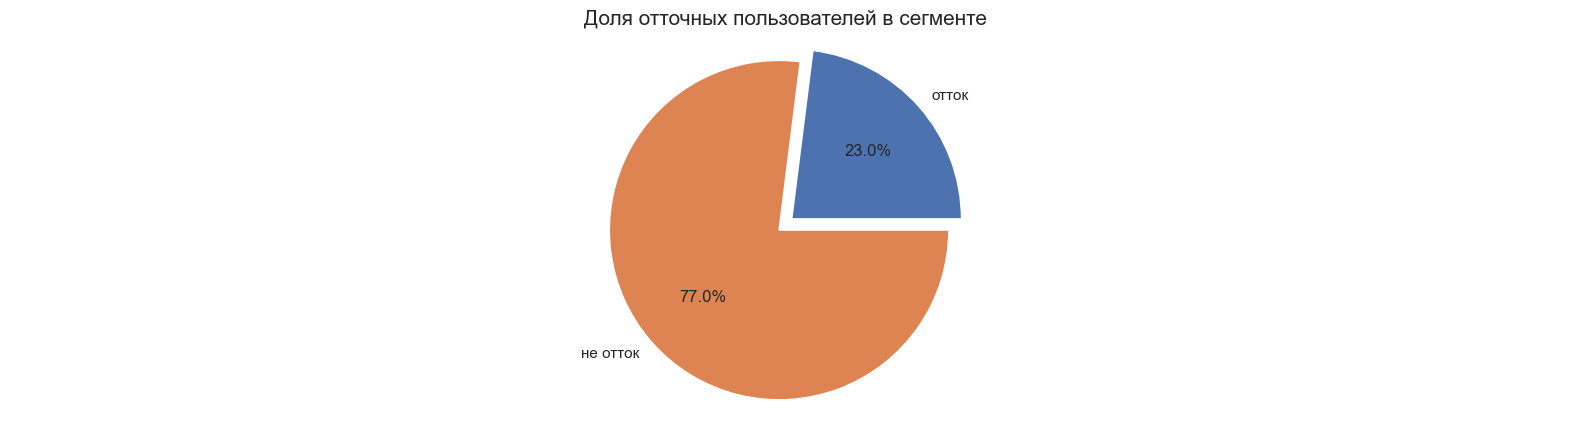

In [40]:
first = bnk.query('gender == "М" and age >= 25 and age <= 45')
plot_churn_rate(first)

Второй сегмент - мужчины с количеством продуктов  2 и более:

Размер сегмента - 3043


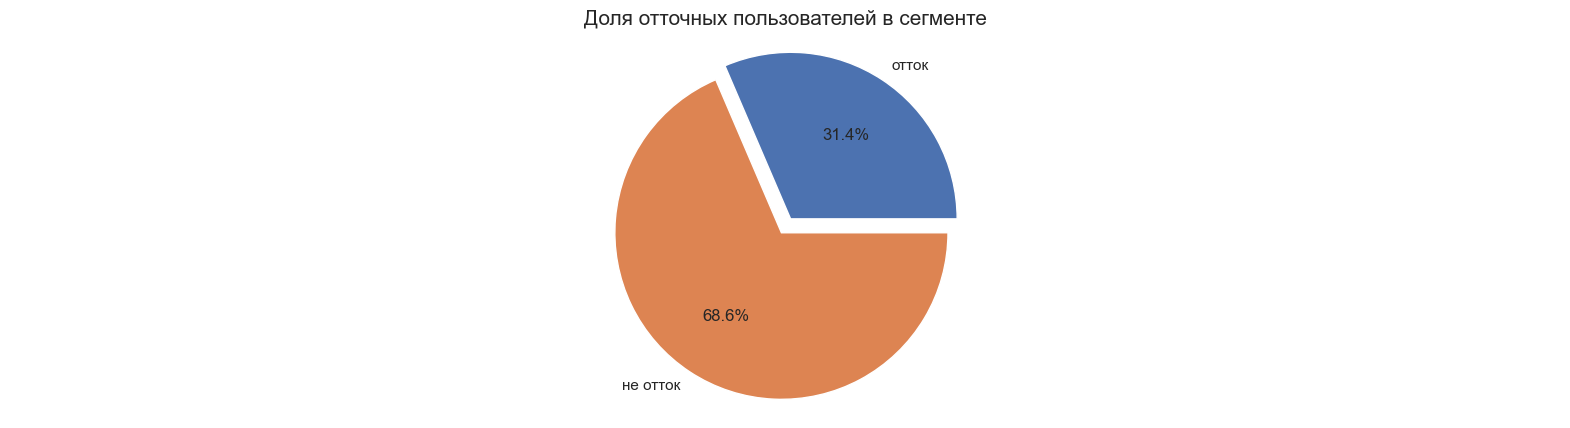

In [41]:
second = bnk.query('gender == "М" and products >= 2')
plot_churn_rate(second)

Третий сегмент - мужчины с количеством собственности 5 и более:

Размер сегмента - 1055


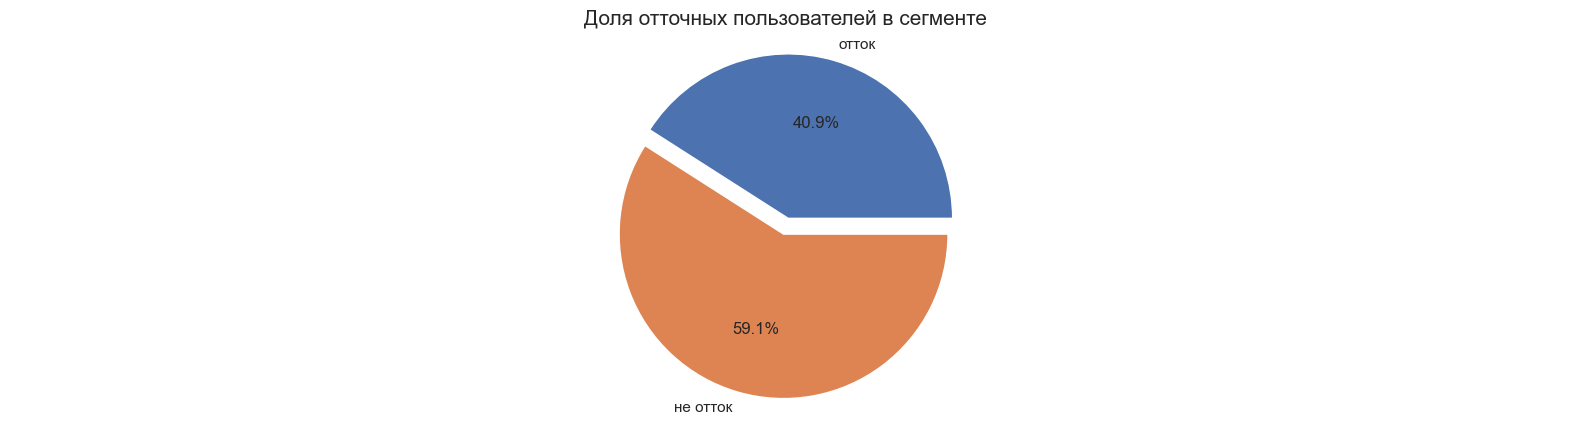

In [42]:
third = bnk.query('gender == "М" and equity >= 5')
plot_churn_rate(third)

Четвертый сегмент - пользователи с кредитным рейтингом больше 820 и балансом больше 300 000:

Размер сегмента - 3804


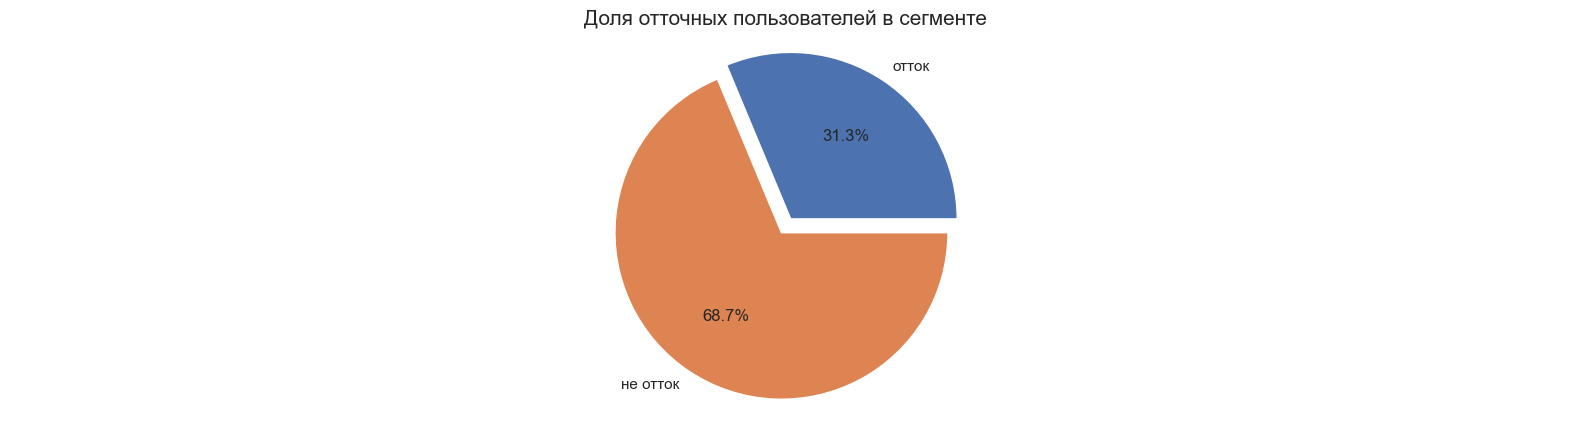

In [43]:
forth = bnk.query('score > 820 and balance > 300000')
plot_churn_rate(forth)

Пятый сегмент - пользователи с прогнозируемым заработком больше 70 000 и наличием кредитной карты:

Размер сегмента - 4916


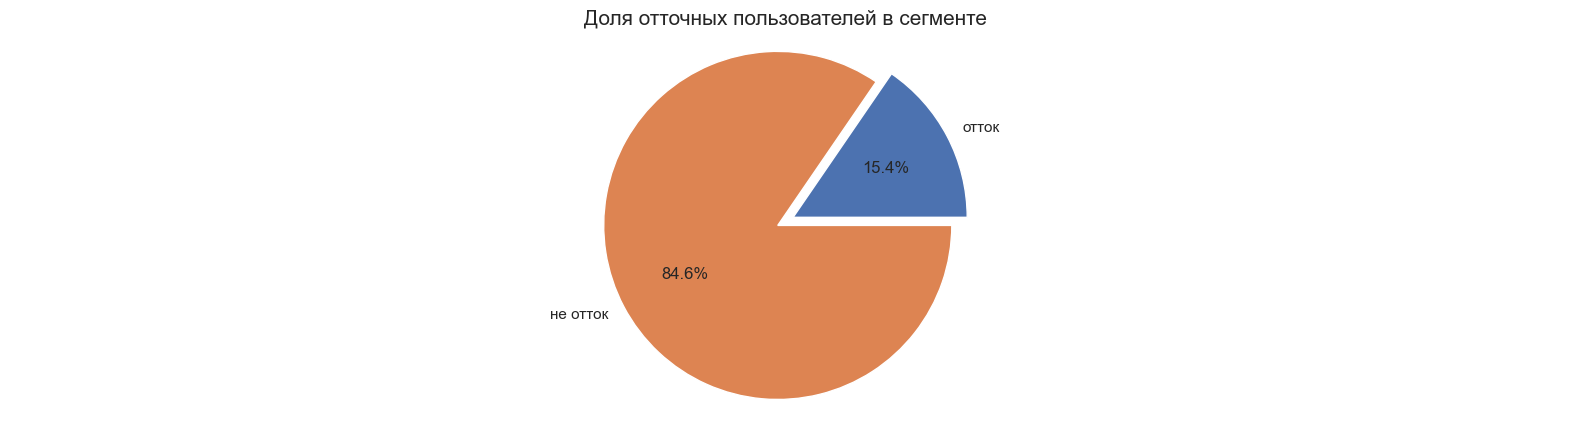

In [44]:
fifth = bnk.query('est_salary > 70000 and credit_card == 1')
plot_churn_rate(fifth)

* Наиболее отточным сегментом стал третий - сегмент с пользователями мужского пола и количеством баллов собственности 5 и более -  почти 50% оттока. 
* На втором месте четвертый сегмент - 31.3% - пользователи с кредитным рейтингом больше 820 и балансом больше 300 000
* На третьем месте месте второй сегмент - мужчины с количеством продуктов 2 и более - почти 30%
* На последнем месте первый сегмент - мужчины от 25 до 45 лет - 23%
* Пятый сегмент пользователей с прогнозируемым заработком больше 70 000 и наличием кредитной карты имеет отток ниже процента по датафрейму - 15.4%

## Рекомендации и выводы<a id="start"></a>

Рекомендации к сегментам:
     
    3 - Предложить лучшие условия страховки имущества или скидку на КАСКО
    4 - Предложить повышенный процент на остаток счета и повышенные ставки по вкладам
    2 - Предложить скидки на услуги банка, повышенный беспроцентный период по кредитной карте
    1 - Скидки на обслуживание дебетовых зарплатных карт
    5 - Предложить скидку на ипотеку, повышенный беспроцентный период по кредитной карте, кредит наличными

В ходе проекта был проведен исследовательский анализ данных с целью определения значимых признаков оттока клиентов банка. Были выявлены интервалы значений характеристик, которые связаны с повышенным оттоком. Была проведена сравнительная характеристика портретов типичных клиентов, склонных и не склонных к уходу из банка.

Были сформулированы и проверены статистические гипотезы. В частности, была проверена гипотеза о различии дохода между клиентами, которые ушли, и теми, кто остался.

Исходя из проведенного анализа данных о клиентах банка "Метанпром", можно сформировать примерный портрет отточного пользователя. Отточными пользователи являются в основном мужчины в возрасте от 25 до 45 лет, проживающие в городе Ярославле. Они обычно имеют кредитный рейтинг в диапазоне 800-925 баллов, баланс на своих счетах составляет от 50 000 до 700 000, а оценочный доход - от 25 000 до 180 000. Среднее количество продуктов в их собственности составляет 2, большинство из которых являются дебетовыми и кредитными картами.

Наибольший отток можно наблюдать среди мужчин  количеством баллов собственности 5 и более, с количеством продуктов 2 и более. Также высокий процент оттока наблюдается у пользователей с кредитным рейтингом 820 и более, имеющих баланс счета больше 300 000. 

На основе признаков оттока были сформированы сегменты клиентов. Из них были отобраны наиболее значимые с точки зрения бизнеса. .
Чтобы снизить уровень оттока пользователей, банку "Метанпром" стоит уделить большее внимание вешеперечисленным сегментам. Предоставление персонализированных предложений и улучшение сервиса для данной группы пользователей может помочь в сокращении оттока и удержании клиентов.

Проект позволил улучшить понимание причин оттока клиентов и предложить подходы к его уменьшению.

дашборд - <https://public.tableau.com/app/profile/daria5569/viz/bank_16965039284840/sheet1?publish=yes>

презентация - <https://docs.google.com/presentation/d/1-IoJmF7ZEQAPC4GjZjdvwxUZs9ASdEjflWu4PVsO_WU/edit#slide=id.g2885742f7a2_0_67>